In [77]:
import numpy as np
import pandas as pd
from sklearn . model_selection import train_test_split
from sklearn . metrics import confusion_matrix ,classification_report
import matplotlib . pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer

In [78]:
df=pd.read_csv('/content/sample_data/diabetes.csv')
df.shape

(768, 9)

In [79]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


change the 0 value to average value

In [80]:
colonnes = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Remplacer 0 par np.nan
df[colonnes] = df[colonnes].replace(0, np.nan)
df[colonnes] = df[colonnes].astype(float)
imputer = SimpleImputer(strategy='median')
df[colonnes] = imputer.fit_transform(df[colonnes])

In [82]:
# Fonctions d’activation
def relu (x ):
  """
  ReLU activation : max (0 , x)
  """
  assert isinstance (x , np . ndarray ) , " Input to ReLU must be a numpy array "

  result = np . maximum (0 , x)
  assert np . all ( result >= 0) , " ReLU output must be non - negative "
  return result

def relu_derivative ( x) :
  """
  Derivative of ReLU : 1 if x > 0 , else 0
  """
  assert isinstance (x , np . ndarray ) , " Input to ReLU derivative must be a numpy array "

  result = np . where (x > 0 , 1 , 0)
  assert np . all (( result == 0) | ( result == 1) ) , " ReLU derivativemust be 0 or 1"
  return result

def sigmoid ( x):
  """
  Sigmoid activation : 1 / (1 + exp ( -x))
  """
  assert isinstance (x , np . ndarray ) , " Input to sigmoid must be anumpy array "

  result = 1 / (1 + np . exp (-x))
  assert np . all (( result >= 0) & ( result <= 1) ) , " Sigmoid output must be in [0 , 1]"

  return result

def sigmoid_derivative (x) :
  """
  Derivative of sigmoid : sigmoid (x) * (1 - sigmoid (x))
  """
  assert isinstance (x , np . ndarray ) , " Input to sigmoid derivative must be a numpy array "

  result = sigmoid (x) * (1 - sigmoid (x))

  assert np . all (( result >= 0) & ( result <= 0.25) ) , " Sigmoid derivative must be in [0 , 0.25] "

  return result

In [87]:
# Classe NeuralNetwork
class NeuralNetwork :
  def __init__ ( self , layer_sizes ,model_optimization ,learning_rate =0.01) :
    """
    Initialize the neural network with given layer sizes and learning rate .

    layer_sizes : List of integers [ input_size , hidden1_size ,

    ... , output_size ]

    """
    assert isinstance ( layer_sizes , list ) and len ( layer_sizes ) >= 2 , " layer_sizes must be a list with at least 2 elements "

    assert all ( isinstance ( size , int ) and size > 0 for size in layer_sizes ) , "All layer sizes must be positive integers "

    assert isinstance ( learning_rate , (int , float )) and learning_rate > 0, " Learning rate must be a positive number "

    self . layer_sizes = layer_sizes
    self . learning_rate = learning_rate
    self . weights = []
    self . biases = []
    self.model_optimization=model_optimization
    # Initialisation des variables pour l'optimiseur Adam




    # Initialisation des poids et biais
    np . random . seed (42)
    for i in range (len ( layer_sizes ) - 1) :
      w = np . random . randn ( layer_sizes [ i] , layer_sizes [ i +1]) * 0.1
      b = np . zeros ((1 , layer_sizes [ i +1]))
      assert w. shape == ( layer_sizes [ i], layer_sizes [ i +1]) , f" Weight matrix {i +1} has incorrect shape "

      assert b. shape == (1 , layer_sizes [ i +1]) , f" Bias vector {i +1} has incorrect shape "

      self . weights . append (w)
      self . biases . append ( b)
    # Initialisation des variables pour l'optimiseur Adam APRÈS l'initialisation des poids et biais
    self.m_w = [np.zeros_like(w) for w in self.weights]
    self.v_w = [np.zeros_like(w) for w in self.weights]
    self.m_b = [np.zeros_like(b) for b in self.biases]
    self.v_b = [np.zeros_like(b) for b in self.biases]
    self.t = 0 # time step
    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = 1e-8 # une variable epsilon pour eviter la division sur 0


  def forward ( self , X) :
    """
    Forward propagation : Z ^{[ l]} = A ^{[l -1]} W ^{[ l]} + b ^{[ l ]} , A^{[ l]} = g(Z ^{[ l ]})

    """
    assert isinstance (X , np . ndarray ) , " Input X must be a numpy array "

    assert X. shape [1] == self . layer_sizes [0] , f" Input dimension ({X. shape [1]}) must match input layer size ({ self . layer_sizes [0]}) "


    self . activations = [X ]

    self . z_values = []

    for i in range (len ( self . weights ) - 1) :
      # z = self . activations [ -1] @ self . weights [ i] + self . biases [ i]
      z=np.dot(self.activations[-1],self.weights[i])+self.biases[i]
      assert z. shape == ( X. shape [0] , self . layer_sizes [i +1]) ,f"Z^{[ i +1]} has incorrect shape "
      self . z_values . append (z )
      a = relu (z )
      assert a. shape == ( X. shape [0] , self . layer_sizes [i +1]) ,f"A^{[ i +1]} has incorrect shape "
      self . activations . append (a )

    z=np.dot(self.activations[-1],self.weights[-1])+self.biases[-1]
    assert z. shape == ( X. shape [0] , self . layer_sizes [ -1]) , " Output Z has incorrect shape "
    self.z_values . append (z )
    output = sigmoid (z )
    assert output . shape == ( X. shape [0] , self . layer_sizes [ -1]) ," Output A has incorrect shape "
    self . activations . append (output )

    return self . activations [ -1]

  def compute_loss ( self , y_true , y_pred ):
    """
    Binary Cross - Entropy : J = -1/m * sum (y * log ( y_pred ) + (1 -y) * log (1 - y_pred ))
    """
    assert isinstance ( y_true , np . ndarray ) and isinstance ( y_pred , np . ndarray ) , " Inputs to loss must be numpy arrays "

    assert y_true . shape == y_pred . shape , " y_true and y_pred must have the same shape "

    assert np . all (( y_true == 0) | ( y_true == 1) ) , " y_true must contain only 0s and 1s"
    m = y_true . shape [0]
    loss = -1 / m * np . sum (y_true * np . log (y_pred) + (1 - y_true) * np . log (1 - y_pred))

    assert not np . isnan ( loss ) , " Loss computation resulted in NaN "

    return loss

  def compute_accuracy ( self , y_true , y_pred ):
    """
    Compute accuracy : proportion of correct predictions
    """
    assert isinstance ( y_true , np . ndarray ) and isinstance (y_pred , np . ndarray ) , " Inputs to accuracy must be numpy arrays "
    assert y_true . shape == y_pred . shape , " y_true and y_pred must have the same shape "


    accuracy=np.mean(y_true==y_pred)
    assert 0 <= accuracy <= 1 , " Accuracy must be between 0 and 1"

    return accuracy



  def backward ( self , X , y , outputs ):
    """
    Backpropagation : compute dW ^{[ l]} , db ^{[ l]} for each layer
    """
    assert isinstance (X , np . ndarray ) and isinstance (y , np .ndarray ) and isinstance ( outputs , np . ndarray ) , " Inputs to backward must be numpy arrays "

    assert X. shape [1] == self . layer_sizes [0] , f" Input dimension ({X. shape [1]}) must match input layer size ({self . layer_sizes [0]}) "

    assert y. shape == outputs . shape , "y and outputs must have the same shape "
    m = X. shape [0]
    self . d_weights = [ np . zeros_like (w ) for w in self . weights ]
    self . d_biases = [ np . zeros_like ( b) for b in self . biases ]
    dZ = outputs - y
    assert dZ . shape == outputs . shape , "dZ for output layer has incorrect shape "

    self . d_weights [ -1] = ( self . activations [ -2]. T @ dZ ) / m
    self . d_biases [ -1] = np .sum (dZ , axis =0 , keepdims = True ) / m
    for i in range (len ( self . weights ) - 2, -1, -1) :
      dA = dZ @ self . weights [ i +1]. T
      dZ = dA * relu_derivative ( self . z_values [ i])



      self . d_weights [ i] = ( self . activations [ i]. T @ dZ ) / m
      self . d_biases [ i] = np . sum (dZ , axis =0 , keepdims = True ) / m
    # TODO : Ajouter une r g u l a r i s a t i o n L2 aux gradients des poids
    # dW ^{[ l]} += lambda * W ^{[ l]} / m, o lambda est le coefficient de r g u l a r i s a t i o n
      lambda_ = 0.01
      for i in range (len ( self . weights )) :
        self . d_weights [ i] += lambda_ * self . weights [ i] / m
      if self.model_optimization == "SGD":
        # calcule avec gradient descent stochastic
        for i in range (len ( self . weights )) :
          self. weights [ i] -= self . learning_rate * self . d_weights [ i]
          self . biases [ i] -= self . learning_rate * self . d_biases [ i]
      elif self.model_optimization == "Adam":
        # calcule avec Adam
        self.t += 1 # Increment time step per batch

        for i in range (len ( self . weights )) :
            # Mise à jour des moments
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * self.d_weights[i]
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (self.d_weights[i]**2)
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * self.d_biases[i]
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (self.d_biases[i]**2)

            # Correctif de biais
            m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)# mise à jour du 1er moment (momentum)
            v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)# mise à jour du 2e moment (RMS)
            m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)# mise à jour du 1er moment (momentum) (sur le biais)
            v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)# mise à jour du 2e moment (RMS)(sur le biais)

            # Update des paramètres
            self . weights [ i] -= self . learning_rate  * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            self . biases [ i] -= self . learning_rate  * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)


  def train ( self , X , y , X_val , y_val , epochs , batch_size ):
    """
    Train the neural network using mini - batch SGD , with

    validation

    """
    assert isinstance (X , np . ndarray ) and isinstance (y , np .ndarray ) , "X and y must be numpy arrays "

    assert isinstance ( X_val , np . ndarray ) and isinstance ( y_val ,np . ndarray ) , " X_val and y_val must be numpy arrays "
    assert X. shape [1] == self . layer_sizes [0] , f" Input dimension ({X. shape [1]}) must match input layer size ({self . layer_sizes [0]}) "

    assert y. shape [1] == self . layer_sizes [ -1] , f" Output dimension ({y. shape [1]}) must match output layer size({ self . layer_sizes [ -1]}) "
    assert X_val . shape [1] == self . layer_sizes [0] , f" Validation input dimension ({ X_val . shape [1]}) must match input layer size ({ self . layer_sizes [0]}) "

    assert y_val . shape [1] == self . layer_sizes [ -1] , f"Validation output dimension ({ y_val . shape [1]}) must match output layer size ({ self . layer_sizes [ -1]}) "
    assert isinstance ( epochs , int ) and epochs > 0, " Epochs must be a positive integer "

    assert isinstance ( batch_size , int ) and batch_size > 0 , "Batch size must be a positive integer "

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range ( epochs ) :
      indices = np . random . permutation (X . shape [0])
      X = X [ indices]
      y = y [ indices]

      epoch_loss = 0
      for i in range (0 , X . shape [0] , batch_size ):
        X_batch = X [ i : i + batch_size ]
        y_batch = y [ i : i + batch_size ]
        outputs = self . forward ( X_batch )
        epoch_loss += self . compute_loss ( y_batch , outputs )
        self . backward ( X_batch , y_batch , outputs )

      # Calculer les pertes et accuracies pour l’e n t r a n e m e n t et la validation
      train_loss = self . compute_loss ( y , self . forward ( X ))
      val_loss = self . compute_loss ( y_val , self . forward ( X_val ))
      train_accuracy = self . compute_accuracy ( y , np . round ( self . forward ( X )))
      val_accuracy = self . compute_accuracy ( y_val , np . round ( self . forward ( X_val )))

      train_losses . append ( train_loss )
      val_losses . append ( val_loss )
      train_accuracies . append ( train_accuracy )
      val_accuracies . append ( val_accuracy )

      if epoch % 10 == 0:
        print (f" Epoch { epoch } , Train Loss : { train_loss :.4f}, Val Loss : { val_loss :.4f} , "f" Train Acc : { train_accuracy :.4f} , Val Acc :{ val_accuracy :.4f}")


    return train_losses , val_losses , train_accuracies ,val_accuracies

  def predict ( self , X) :
    """
    Predict class labels (0 or 1)
    """
    assert isinstance (X , np . ndarray ) , " Input X must be a numpy array "
    assert X. shape [1] == self . layer_sizes [0] , f" Input dimension ({X. shape [1]}) must match input layer size ({self . layer_sizes [0]}) "
    predictions = self . forward ( X )
    predictions [ predictions <= 0.5] = 0
    predictions [ predictions > 0.5] = 1

    assert predictions . shape == ( X. shape [0] , self . layer_sizes[ -1]) , " Predictions have incorrect shape "

    return predictions

Training and testing with SGD

 Epoch 0 , Train Loss : 0.6864, Val Loss : 0.6872 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 10 , Train Loss : 0.6556, Val Loss : 0.6570 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 20 , Train Loss : 0.6481, Val Loss : 0.6498 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 30 , Train Loss : 0.6446, Val Loss : 0.6459 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 40 , Train Loss : 0.6421, Val Loss : 0.6429 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 50 , Train Loss : 0.6393, Val Loss : 0.6395 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 60 , Train Loss : 0.6352, Val Loss : 0.6347 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 70 , Train Loss : 0.6283, Val Loss : 0.6267 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 80 , Train Loss : 0.6163, Val Loss : 0.6130 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 90 , Train Loss : 0.5960, Val Loss : 0.5897 ,  Train Acc : 0.6522 , Val Acc :0.6494
\ nRapport de classification ( Test set ) :
              precision    recall  f1-score   s

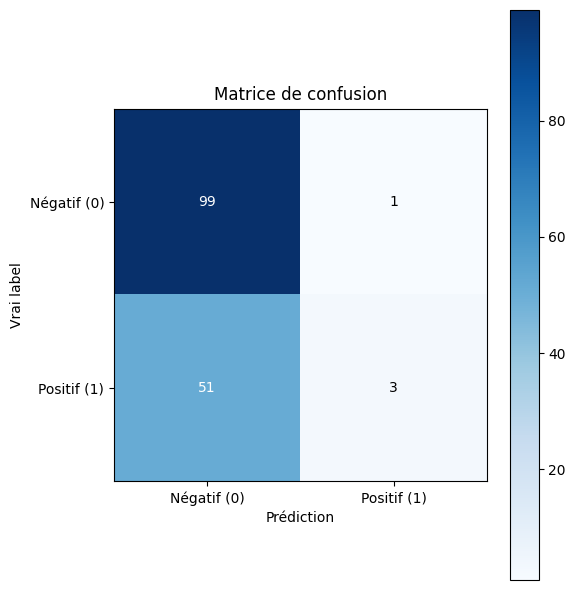

In [88]:
# Charger et p r p a r e r les d o n n e s
data=pd.read_csv('/content/sample_data/diabetes.csv')
X=data.drop('Outcome',axis=1).values
y=data['Outcome'].values
assert X. shape [0] == y. shape [0] , " Number of samples in X and y must match "
assert X. shape [1] == 8, " Expected 8 features in input data "

# Standardisation : X = (X - mu) / sigma
mu = np . mean (X , axis =0)
sigma = np . std (X , axis =0)
X = (X - mu) / sigma

# Diviser les d o n n e s en e n t r a n e m e n t , validation et test
X_temp , X_test , y_temp , y_test = train_test_split (X , y , test_size=0.2 , stratify =y , random_state =42)
X_train , X_val , y_train , y_val = train_test_split ( X_temp , y_temp ,test_size =0.25 , stratify = y_temp , random_state =42)
 # 0.25 x 0.8= 0.2
assert X_train . shape [0] + X_val . shape [0] + X_test . shape [0] == X.shape [0] , "Train -val - test split sizes must sum to total samples"

# Reshape target variables to be 2D
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


# C r e r et e n t r a n e r le m o d l e

# TODO : Ajouter une validation c r o i s e pour valuer la robustesse du m o d l e

# **IMPORTANT** : ré-instancier à chaque fold pour repartir à zéro
layer_sizes = [ X_train . shape [1], 16, 8, 1]
nn = NeuralNetwork ( layer_sizes , model_optimization="SGD",learning_rate =0.01)

# 1) entraînement
train_losses , val_losses , train_accuracies , val_accuracies = nn .train ( X_train , y_train , X_val , y_val , epochs =100 , batch_size=32)

# 2) prédiction
y_pred = nn.predict(X_test)


# TODO : I m p l m e n t e r l’optimiseur Adam pour une meilleure convergence

# P r d i c t i o n s et valuation
y_pred = nn . predict ( X_test )
print ("\ nRapport de classification ( Test set ) :")
print ( classification_report ( y_test , y_pred ))

# Matrice de confusion
cm = confusion_matrix ( y_test , y_pred )
print ("\ nMatrice de confusion ( Test set ) :")
print ( cm )


# 2) Affichage avec matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# 3) Configuration des labels
classes = ['Négatif (0)', 'Positif (1)']
ax.set(
    xticks=[0, 1],
    yticks=[0, 1],
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title="Matrice de confusion"
)

# 4) Annotation de chaque case
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

 Epoch 0 , Train Loss : 0.6864, Val Loss : 0.6872 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 10 , Train Loss : 0.6556, Val Loss : 0.6570 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 20 , Train Loss : 0.6481, Val Loss : 0.6498 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 30 , Train Loss : 0.6446, Val Loss : 0.6459 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 40 , Train Loss : 0.6421, Val Loss : 0.6429 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 50 , Train Loss : 0.6393, Val Loss : 0.6395 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 60 , Train Loss : 0.6352, Val Loss : 0.6347 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 70 , Train Loss : 0.6283, Val Loss : 0.6267 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 80 , Train Loss : 0.6163, Val Loss : 0.6130 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 90 , Train Loss : 0.5960, Val Loss : 0.5897 ,  Train Acc : 0.6522 , Val Acc :0.6494


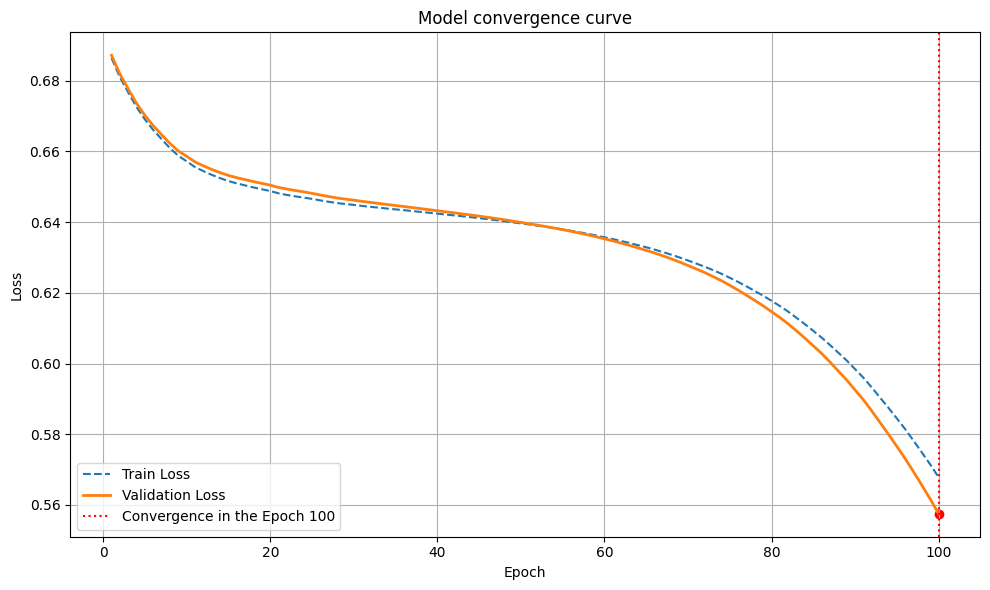

\ nRapport de classification ( Test set ) :
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       100
           1       0.75      0.06      0.10        54

    accuracy                           0.66       154
   macro avg       0.71      0.52      0.45       154
weighted avg       0.69      0.66      0.55       154



In [89]:
# Reshape target variables to be 2D
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


# C r e r et e n t r a n e r le m o d l e

# TODO : Ajouter une validation c r o i s e pour valuer la robustesse du m o d l e

# *IMPORTANT* : ré-instancier à chaque fold pour repartir à zéro
layer_sizes = [ X_train . shape [1],16, 8, 1]
nn = NeuralNetwork ( layer_sizes , model_optimization="SGD",learning_rate =0.01)

# 1) entraînement
train_losses , val_losses , train_accuracies , val_accuracies = nn .train ( X_train , y_train , X_val , y_val , epochs =100 , batch_size=32)
epochs = range(1, len(train_losses) + 1)

# --- Détermination de l’epoch de convergence ---
# Ici : critère = minimum de la val_loss
best_epoch = np.argmin(val_losses) + 1
best_val_loss = val_losses[best_epoch - 1]

# Tu peux aussi utiliser : best_epoch = np.argmax(val_accuracies) + 1

# --- Affichage ---
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss", linestyle='--')
plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)
plt.axvline(best_epoch, color='red', linestyle=':', label=f"Convergence in the Epoch {best_epoch}")
plt.scatter(best_epoch, best_val_loss, color='red')
plt.title("Model convergence curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) prédiction
y_pred = nn.predict(X_test)


# TODO : I m p l m e n t e r l’optimiseur Adam pour une meilleure convergence

# P r d i c t i o n s et valuation
y_pred = nn . predict ( X_test )
print ("\ nRapport de classification ( Test set ) :")
print ( classification_report ( y_test , y_pred ))

Adding the cross validation

 Epoch 0 , Train Loss : 0.6874, Val Loss : 0.6881 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.6589, Val Loss : 0.6598 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 20 , Train Loss : 0.6500, Val Loss : 0.6511 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 30 , Train Loss : 0.6466, Val Loss : 0.6479 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 40 , Train Loss : 0.6444, Val Loss : 0.6460 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 50 , Train Loss : 0.6425, Val Loss : 0.6443 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 60 , Train Loss : 0.6401, Val Loss : 0.6427 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 70 , Train Loss : 0.6372, Val Loss : 0.6404 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 80 , Train Loss : 0.6330, Val Loss : 0.6371 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 90 , Train Loss : 0.6267, Val Loss : 0.6319 ,  Train Acc : 0.6522 , Val Acc :0.6522
Fold 1 — acc:0.652, f1:0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Epoch 0 , Train Loss : 0.6878, Val Loss : 0.6868 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.6585, Val Loss : 0.6577 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 20 , Train Loss : 0.6500, Val Loss : 0.6492 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 30 , Train Loss : 0.6465, Val Loss : 0.6456 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 40 , Train Loss : 0.6444, Val Loss : 0.6433 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 50 , Train Loss : 0.6426, Val Loss : 0.6415 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 60 , Train Loss : 0.6404, Val Loss : 0.6393 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 70 , Train Loss : 0.6375, Val Loss : 0.6365 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 80 , Train Loss : 0.6334, Val Loss : 0.6325 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 90 , Train Loss : 0.6271, Val Loss : 0.6265 ,  Train Acc : 0.6522 , Val Acc :0.6522


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 — acc:0.652, f1:0.000
 Epoch 0 , Train Loss : 0.6875, Val Loss : 0.6878 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.6590, Val Loss : 0.6595 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 20 , Train Loss : 0.6500, Val Loss : 0.6506 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 30 , Train Loss : 0.6467, Val Loss : 0.6474 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 40 , Train Loss : 0.6446, Val Loss : 0.6449 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 50 , Train Loss : 0.6428, Val Loss : 0.6428 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 60 , Train Loss : 0.6408, Val Loss : 0.6405 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 70 , Train Loss : 0.6384, Val Loss : 0.6377 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 80 , Train Loss : 0.6350, Val Loss : 0.6337 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 90 , Train Loss : 0.6299, Val Loss : 0.6280 ,  Train Acc : 0.6522 , Val Acc :0.6522
Fold 3 — acc:0.652, f1:0.000
 Epoch 0 , Train Loss : 0.6876, V

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Epoch 40 , Train Loss : 0.6436, Val Loss : 0.6444 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 50 , Train Loss : 0.6415, Val Loss : 0.6425 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 60 , Train Loss : 0.6392, Val Loss : 0.6401 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 70 , Train Loss : 0.6360, Val Loss : 0.6370 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 80 , Train Loss : 0.6313, Val Loss : 0.6327 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 90 , Train Loss : 0.6242, Val Loss : 0.6260 ,  Train Acc : 0.6522 , Val Acc :0.6522
Fold 4 — acc:0.652, f1:0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Epoch 0 , Train Loss : 0.6875, Val Loss : 0.6874 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.6593, Val Loss : 0.6592 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 20 , Train Loss : 0.6503, Val Loss : 0.6502 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 30 , Train Loss : 0.6461, Val Loss : 0.6464 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 40 , Train Loss : 0.6435, Val Loss : 0.6442 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 50 , Train Loss : 0.6410, Val Loss : 0.6424 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 60 , Train Loss : 0.6382, Val Loss : 0.6404 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 70 , Train Loss : 0.6343, Val Loss : 0.6375 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 80 , Train Loss : 0.6284, Val Loss : 0.6331 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 90 , Train Loss : 0.6191, Val Loss : 0.6261 ,  Train Acc : 0.6522 , Val Acc :0.6522
Fold 5 — acc:0.652, f1:0.000
accuracy : 0.652 ± 0.000
precision: 0.000 ± 0.000
recall   : 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

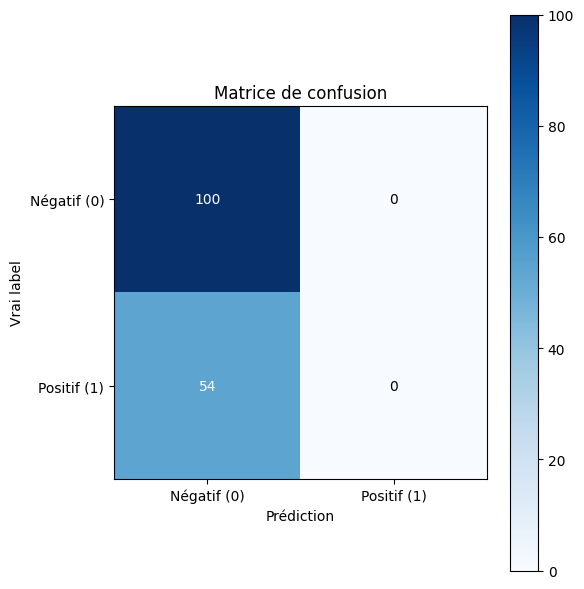

In [90]:
# Charger et p r p a r e r les d o n n e s
data=pd.read_csv('/content/sample_data/diabetes.csv')
X=data.drop('Outcome',axis=1).values
y=data['Outcome'].values
assert X. shape [0] == y. shape [0] , " Number of samples in X and y must match "
assert X. shape [1] == 8, " Expected 8 features in input data "

# Standardisation : X = (X - mu) / sigma
mu = np . mean (X , axis =0)
sigma = np . std (X , axis =0)
X = (X - mu) / sigma

# Diviser les d o n n e s en e n t r a n e m e n t , validation et test
X_temp , X_test , y_temp , y_test = train_test_split (X , y , test_size=0.2 , stratify =y , random_state =42)
X_train , X_val , y_train , y_val = train_test_split ( X_temp , y_temp ,test_size =0.25 , stratify = y_temp , random_state =42)
 # 0.25 x 0.8= 0.2
assert X_train . shape [0] + X_val . shape [0] + X_test . shape [0] == X.shape [0] , "Train -val - test split sizes must sum to total samples"

# Reshape target variables to be 2D
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


# C r e r et e n t r a n e r le m o d l e

# TODO : Ajouter une validation c r o i s e pour valuer la robustesse du m o d l e
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = {m: [] for m in ('accuracy','precision','recall','f1')}
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_va, y_va = X_train[test_idx], y_train[test_idx]

    # Reshape target variables to be 2D
    y_tr = y_tr.reshape(-1, 1)
    y_va = y_va.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # **IMPORTANT** : ré-instancier à chaque fold pour repartir à zéro
    layer_sizes = [ X_tr . shape [1], 16, 8, 1]
    nn = NeuralNetwork ( layer_sizes , model_optimization="SGD",learning_rate =0.01)

    # 1) entraînement
    train_losses , val_losses , train_accuracies , val_accuracies = nn .train ( X_tr , y_tr , X_va , y_va , epochs =100 , batch_size=32)

    # 2) prédiction
    y_pred = nn.predict(X_va)

    # 3) calcul des métriques
    scores['accuracy'].append(accuracy_score(y_va, y_pred))
    scores['precision'].append(precision_score(y_va, y_pred))
    scores['recall'].append(recall_score(y_va, y_pred))
    scores['f1'].append(f1_score(y_va, y_pred))

    print(f"Fold {fold} — acc:{scores['accuracy'][-1]:.3f}, "
          f"f1:{scores['f1'][-1]:.3f}")

# Enfin moyenne et écart-type
for m in scores:
    arr = np.array(scores[m])
    print(f"{m:9s}: {arr.mean():.3f} ± {arr.std():.3f}")


# TODO : I m p l m e n t e r l’optimiseur Adam pour une meilleure convergence

# P r d i c t i o n s et valuation
y_pred = nn . predict ( X_test )
print ("\ nRapport de classification ( Test set ) :")
print ( classification_report ( y_test , y_pred ))

# Matrice de confusion
cm = confusion_matrix ( y_test , y_pred )
print ("\ nMatrice de confusion ( Test set ) :")
print ( cm )


# 2) Affichage avec matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# 3) Configuration des labels
classes = ['Négatif (0)', 'Positif (1)']
ax.set(
    xticks=[0, 1],
    yticks=[0, 1],
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title="Matrice de confusion"
)

# 4) Annotation de chaque case
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

Trianing and testing with Adam and Cross validation

 Epoch 0 , Train Loss : 0.5427, Val Loss : 0.5338 ,  Train Acc : 0.7120 , Val Acc :0.6848
 Epoch 10 , Train Loss : 0.4275, Val Loss : 0.4803 ,  Train Acc : 0.8043 , Val Acc :0.7935
 Epoch 20 , Train Loss : 0.3967, Val Loss : 0.5498 ,  Train Acc : 0.7908 , Val Acc :0.7826
 Epoch 30 , Train Loss : 0.3422, Val Loss : 0.5719 ,  Train Acc : 0.8451 , Val Acc :0.7391
 Epoch 40 , Train Loss : 0.3069, Val Loss : 0.6501 ,  Train Acc : 0.8614 , Val Acc :0.7391
 Epoch 50 , Train Loss : 0.2737, Val Loss : 0.6672 ,  Train Acc : 0.8723 , Val Acc :0.7391
 Epoch 60 , Train Loss : 0.2471, Val Loss : 0.7643 ,  Train Acc : 0.8995 , Val Acc :0.7065
 Epoch 70 , Train Loss : 0.2555, Val Loss : 0.8586 ,  Train Acc : 0.8913 , Val Acc :0.7391
 Epoch 80 , Train Loss : 0.2462, Val Loss : 0.8286 ,  Train Acc : 0.8940 , Val Acc :0.7065
 Epoch 90 , Train Loss : 0.1871, Val Loss : 0.8365 ,  Train Acc : 0.9212 , Val Acc :0.7174
Fold 1 — acc:0.674, f1:0.559
 Epoch 0 , Train Loss : 0.5423, Val Loss : 0.5551 ,  Train Acc

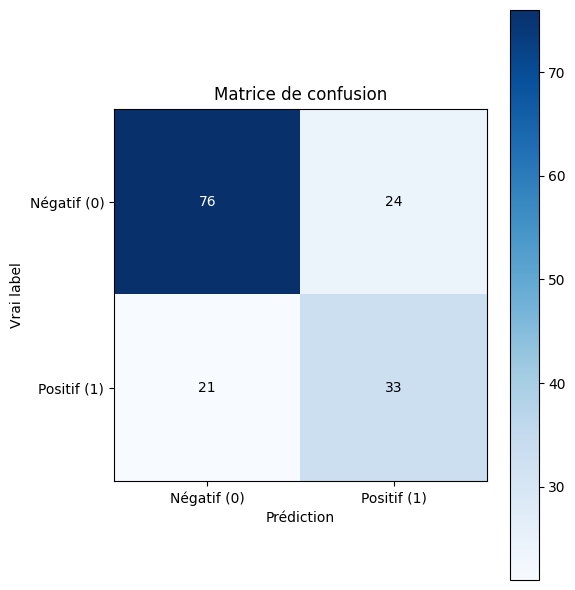

In [91]:
# Charger et p r p a r e r les d o n n e s
data=pd.read_csv('/content/sample_data/diabetes.csv')
X=data.drop('Outcome',axis=1).values
y=data['Outcome'].values
assert X. shape [0] == y. shape [0] , " Number of samples in X and y must match "
assert X. shape [1] == 8, " Expected 8 features in input data "

# Standardisation : X = (X - mu) / sigma
mu = np . mean (X , axis =0)
sigma = np . std (X , axis =0)
X = (X - mu) / sigma

# Diviser les d o n n e s en e n t r a n e m e n t , validation et test
X_temp , X_test , y_temp , y_test = train_test_split (X , y , test_size=0.2 , stratify =y , random_state =42)
X_train , X_val , y_train , y_val = train_test_split ( X_temp , y_temp ,test_size =0.25 , stratify = y_temp , random_state =42)
 # 0.25 x 0.8= 0.2
assert X_train . shape [0] + X_val . shape [0] + X_test . shape [0] == X.shape [0] , "Train -val - test split sizes must sum to total samples"

# Reshape target variables to be 2D
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


# C r e r et e n t r a n e r le m o d l e

# TODO : Ajouter une validation c r o i s e pour valuer la robustesse du m o d l e
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = {m: [] for m in ('accuracy','precision','recall','f1')}
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_va, y_va = X_train[test_idx], y_train[test_idx]

    # Reshape target variables to be 2D
    y_tr = y_tr.reshape(-1, 1)
    y_va = y_va.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # **IMPORTANT** : ré-instancier à chaque fold pour repartir à zéro
    layer_sizes = [ X_tr . shape [1], 16, 8, 1]
    nn = NeuralNetwork ( layer_sizes , model_optimization="Adam",learning_rate =0.01)

    # 1) entraînement
    train_losses , val_losses , train_accuracies , val_accuracies = nn .train ( X_tr , y_tr , X_va , y_va , epochs =100 , batch_size=32)

    # 2) prédiction
    y_pred = nn.predict(X_va)

    # 3) calcul des métriques
    scores['accuracy'].append(accuracy_score(y_va, y_pred))
    scores['precision'].append(precision_score(y_va, y_pred))
    scores['recall'].append(recall_score(y_va, y_pred))
    scores['f1'].append(f1_score(y_va, y_pred))

    print(f"Fold {fold} — acc:{scores['accuracy'][-1]:.3f}, "
          f"f1:{scores['f1'][-1]:.3f}")

# Enfin moyenne et écart-type
for m in scores:
    arr = np.array(scores[m])
    print(f"{m:9s}: {arr.mean():.3f} ± {arr.std():.3f}")


# TODO : I m p l m e n t e r l’optimiseur Adam pour une meilleure convergence

# P r d i c t i o n s et valuation
y_pred = nn . predict ( X_test )
print ("\ nRapport de classification ( Test set ) :")
print ( classification_report ( y_test , y_pred ))

# Matrice de confusion
cm = confusion_matrix ( y_test , y_pred )
print ("\ nMatrice de confusion ( Test set ) :")
print ( cm )


# 2) Affichage avec matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# 3) Configuration des labels
classes = ['Négatif (0)', 'Positif (1)']
ax.set(
    xticks=[0, 1],
    yticks=[0, 1],
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title="Matrice de confusion"
)

# 4) Annotation de chaque case
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

testing different learning rate

In [92]:

# 3. Validation croisée sur X_train / y_train
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
learning_rates = [0.001, 0.01, 0.1]
scores_by_lr = {lr: {'accuracy': []} for lr in learning_rates}

# Dimensions du réseau
layer_sizes = [X_train.shape[1], 16, 8, 1]

for fold, (idx_tr, idx_va) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
    X_va, y_va = X_train[idx_va], y_train[idx_va]
    # Si votre modèle attend y en 2D :
    y_tr = y_tr.reshape(-1, 1)
    y_va = y_va.reshape(-1, 1)

    for lr in learning_rates:

        nn = NeuralNetwork(layer_sizes,model_optimization="Adam", learning_rate=lr)
        # Entraînement (100 epochs par exemple)
        nn.train(X_tr, y_tr, X_va, y_va, epochs=100, batch_size=16)
        # Prédiction sur le fold de validation
        y_pred_va = nn.predict(X_va)
        # Seuil binaire
        y_pred_va = (y_pred_va > 0.5).astype(int)
        # Stockage de l'accuracy
        scores_by_lr[lr]['accuracy'].append(
            accuracy_score(y_va.ravel(), y_pred_va.ravel())
        )

# 4. Construction du DataFrame récapitulatif
summary = []
for lr, metrics in scores_by_lr.items():
    acc = np.array(metrics['accuracy'])
    summary.append({
        'Learning rate'   : lr,
        'Accuracy moyenne': acc.mean(),
        'Écart-type'      : acc.std()
    })

df_summary = pd.DataFrame(summary)
# Formatage
df_summary['Accuracy moyenne'] = df_summary['Accuracy moyenne'].round(3)
df_summary['Écart-type']       = df_summary['Écart-type']      \
                                    .round(3)                 \
                                    .apply(lambda x: f"± {x}")

# Affichage du tableau Markdown
print(df_summary.to_markdown(index=False))

 Epoch 0 , Train Loss : 0.6784, Val Loss : 0.6799 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.4583, Val Loss : 0.4690 ,  Train Acc : 0.7935 , Val Acc :0.7826
 Epoch 20 , Train Loss : 0.4438, Val Loss : 0.4649 ,  Train Acc : 0.7908 , Val Acc :0.7717
 Epoch 30 , Train Loss : 0.4342, Val Loss : 0.4630 ,  Train Acc : 0.8043 , Val Acc :0.7826
 Epoch 40 , Train Loss : 0.4258, Val Loss : 0.4677 ,  Train Acc : 0.8179 , Val Acc :0.7826
 Epoch 50 , Train Loss : 0.4180, Val Loss : 0.4742 ,  Train Acc : 0.8125 , Val Acc :0.7717
 Epoch 60 , Train Loss : 0.4085, Val Loss : 0.4765 ,  Train Acc : 0.8207 , Val Acc :0.7826
 Epoch 70 , Train Loss : 0.3989, Val Loss : 0.4840 ,  Train Acc : 0.8152 , Val Acc :0.7935
 Epoch 80 , Train Loss : 0.3889, Val Loss : 0.4950 ,  Train Acc : 0.8234 , Val Acc :0.7826
 Epoch 90 , Train Loss : 0.3803, Val Loss : 0.5017 ,  Train Acc : 0.8234 , Val Acc :0.7717
 Epoch 0 , Train Loss : 0.5019, Val Loss : 0.4909 ,  Train Acc : 0.7527 , Val Acc :0.7609
 

 Epoch 0 , Train Loss : 0.6845, Val Loss : 0.6859 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.4774, Val Loss : 0.4833 ,  Train Acc : 0.7772 , Val Acc :0.7717
 Epoch 20 , Train Loss : 0.4506, Val Loss : 0.4678 ,  Train Acc : 0.7962 , Val Acc :0.7609
 Epoch 30 , Train Loss : 0.4407, Val Loss : 0.4625 ,  Train Acc : 0.7989 , Val Acc :0.7826
 Epoch 40 , Train Loss : 0.4337, Val Loss : 0.4657 ,  Train Acc : 0.8016 , Val Acc :0.7717
 Epoch 50 , Train Loss : 0.4269, Val Loss : 0.4656 ,  Train Acc : 0.8179 , Val Acc :0.7826
 Epoch 60 , Train Loss : 0.4198, Val Loss : 0.4654 ,  Train Acc : 0.8098 , Val Acc :0.7717
 Epoch 70 , Train Loss : 0.4132, Val Loss : 0.4645 ,  Train Acc : 0.8179 , Val Acc :0.7826
 Epoch 80 , Train Loss : 0.4062, Val Loss : 0.4724 ,  Train Acc : 0.8179 , Val Acc :0.7935
 Epoch 90 , Train Loss : 0.3992, Val Loss : 0.4785 ,  Train Acc : 0.8207 , Val Acc :0.7826
 Epoch 0 , Train Loss : 0.5427, Val Loss : 0.5338 ,  Train Acc : 0.7120 , Val Acc :0.6848
 

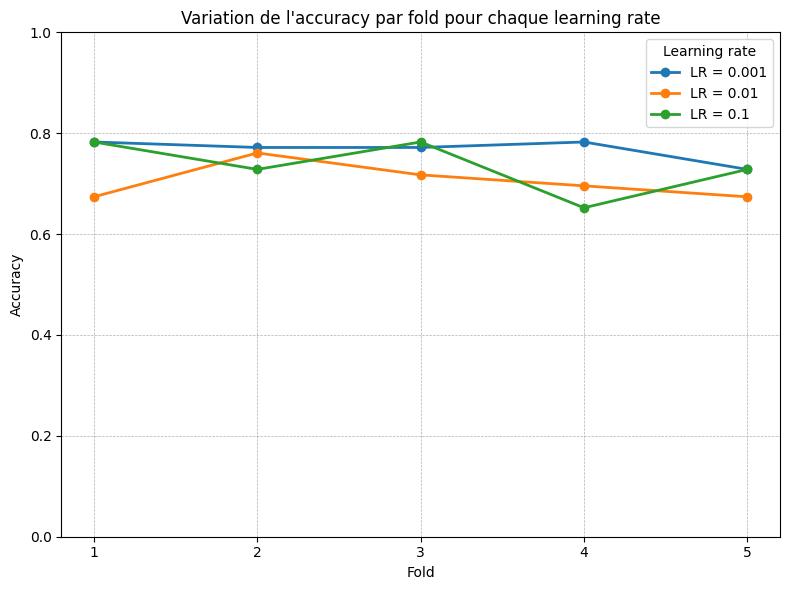

In [93]:


# 3. Validation croisée sur X_train / y_train
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
learning_rates = [0.001, 0.01, 0.1]

# Initialisation du dictionnaire des scores
scores_by_lr = {lr: {'accuracy': []} for lr in learning_rates}

# Dimensions du réseau
layer_sizes = [X_train.shape[1], 16, 8, 1]

for fold, (idx_tr, idx_va) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
    X_va, y_va = X_train[idx_va], y_train[idx_va]
    # reshape si nécessaire
    y_tr = y_tr.reshape(-1, 1)
    y_va = y_va.reshape(-1, 1)

    for lr in learning_rates:
        # Ré-instanciation du modèle
        nn = NeuralNetwork(layer_sizes, model_optimization="Adam", learning_rate=lr)
        # Entraînement
        nn.train(X_tr, y_tr, X_va, y_va, epochs=100, batch_size=32)
        # Prédiction sur le fold de validation
        y_pred_va = nn.predict(X_va)
        y_pred_va = (y_pred_va > 0.5).astype(int)
        # Stockage de l'accuracy
        acc = accuracy_score(y_va.ravel(), y_pred_va.ravel())
        scores_by_lr[lr]['accuracy'].append(acc)

# 4. Génération du graphique : accuracy par fold pour chaque learning rate
n_folds = len(next(iter(scores_by_lr.values()))['accuracy'])
folds = np.arange(1, n_folds + 1)

plt.figure(figsize=(8, 6))
for lr, metrics in scores_by_lr.items():
    accs = metrics['accuracy']
    plt.plot(folds, accs, marker='o', linewidth=2, label=f'LR = {lr}')

plt.title("Variation de l'accuracy par fold pour chaque learning rate")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.xticks(folds)
plt.ylim(0.0, 1.0)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title="Learning rate")
plt.tight_layout()
plt.show()

testing different batch size

 Epoch 0 , Train Loss : 0.6602, Val Loss : 0.6631 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.4514, Val Loss : 0.4635 ,  Train Acc : 0.7962 , Val Acc :0.7826
 Epoch 20 , Train Loss : 0.4384, Val Loss : 0.4606 ,  Train Acc : 0.7962 , Val Acc :0.7717
 Epoch 30 , Train Loss : 0.4294, Val Loss : 0.4628 ,  Train Acc : 0.8071 , Val Acc :0.7717
 Epoch 40 , Train Loss : 0.4216, Val Loss : 0.4680 ,  Train Acc : 0.8125 , Val Acc :0.7826
 Epoch 50 , Train Loss : 0.4137, Val Loss : 0.4696 ,  Train Acc : 0.8125 , Val Acc :0.7826
 Epoch 60 , Train Loss : 0.4040, Val Loss : 0.4695 ,  Train Acc : 0.8234 , Val Acc :0.7935
 Epoch 70 , Train Loss : 0.3957, Val Loss : 0.4740 ,  Train Acc : 0.8207 , Val Acc :0.8043
 Epoch 80 , Train Loss : 0.3831, Val Loss : 0.4875 ,  Train Acc : 0.8234 , Val Acc :0.7935
 Epoch 90 , Train Loss : 0.3714, Val Loss : 0.4876 ,  Train Acc : 0.8288 , Val Acc :0.8152
 Epoch 0 , Train Loss : 0.6784, Val Loss : 0.6799 ,  Train Acc : 0.6522 , Val Acc :0.6522
 

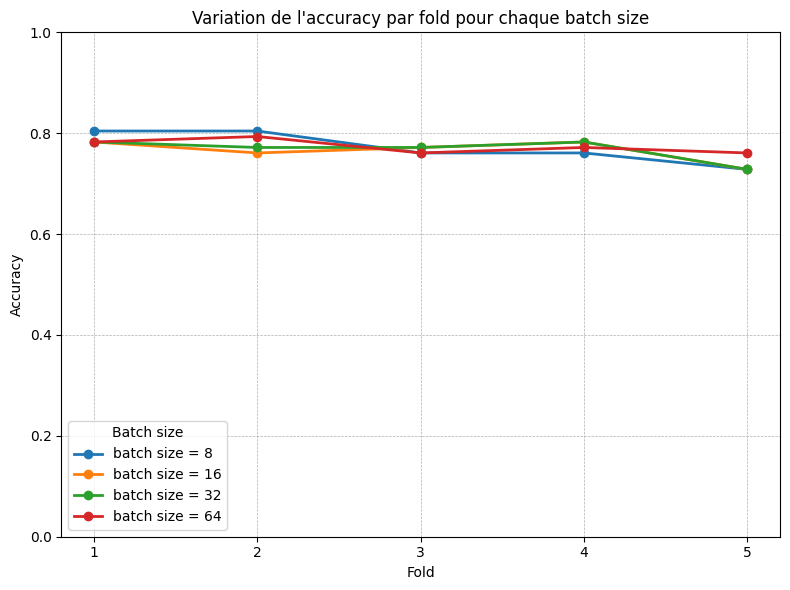

In [94]:


# 3. Validation croisée sur X_train / y_train
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
batch_sizes = [8,16, 32, 64]

# Initialisation du dictionnaire des scores
scores_by_batch = {bt: {'accuracy': []} for bt in batch_sizes}

# Dimensions du réseau
layer_sizes = [X_train.shape[1], 16, 8, 1]

for fold, (idx_tr, idx_va) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
    X_va, y_va = X_train[idx_va], y_train[idx_va]
    # reshape si nécessaire
    y_tr = y_tr.reshape(-1, 1)
    y_va = y_va.reshape(-1, 1)

    for bt in batch_sizes:
        # Ré-instanciation du modèle
        nn = NeuralNetwork(layer_sizes,model_optimization= "Adam", learning_rate=0.001)
        # Entraînement
        nn.train(X_tr, y_tr, X_va, y_va, epochs=100, batch_size=bt)
        # Prédiction sur le fold de validation
        y_pred_va = nn.predict(X_va)
        y_pred_va = (y_pred_va > 0.5).astype(int)
        # Stockage de l'accuracy
        acc = accuracy_score(y_va.ravel(), y_pred_va.ravel())
        scores_by_batch[bt]['accuracy'].append(acc)

# 4. Génération du graphique : accuracy par fold pour chaque learning rate
n_folds = len(next(iter(scores_by_batch.values()))['accuracy'])
folds = np.arange(1, n_folds + 1)

plt.figure(figsize=(8, 6))
for bt, metrics in scores_by_batch.items():
    accs = metrics['accuracy']
    plt.plot(folds, accs, marker='o', linewidth=2, label=f'batch size = {bt}')

plt.title("Variation de l'accuracy par fold pour chaque batch size")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.xticks(folds)
plt.ylim(0.0, 1.0)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title="Batch size")
plt.tight_layout()
plt.show()

testing different number of epochs

 Epoch 0 , Train Loss : 0.6885, Val Loss : 0.6895 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.5433, Val Loss : 0.5448 ,  Train Acc : 0.7418 , Val Acc :0.7065
 Epoch 20 , Train Loss : 0.4662, Val Loss : 0.4727 ,  Train Acc : 0.7799 , Val Acc :0.7609
 Epoch 30 , Train Loss : 0.4506, Val Loss : 0.4625 ,  Train Acc : 0.7962 , Val Acc :0.7717
 Epoch 40 , Train Loss : 0.4421, Val Loss : 0.4609 ,  Train Acc : 0.8016 , Val Acc :0.7609
 Epoch 0 , Train Loss : 0.6885, Val Loss : 0.6895 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.5433, Val Loss : 0.5448 ,  Train Acc : 0.7418 , Val Acc :0.7065
 Epoch 20 , Train Loss : 0.4662, Val Loss : 0.4727 ,  Train Acc : 0.7799 , Val Acc :0.7609
 Epoch 30 , Train Loss : 0.4506, Val Loss : 0.4625 ,  Train Acc : 0.7962 , Val Acc :0.7717
 Epoch 40 , Train Loss : 0.4421, Val Loss : 0.4609 ,  Train Acc : 0.8016 , Val Acc :0.7609
 Epoch 50 , Train Loss : 0.4355, Val Loss : 0.4610 ,  Train Acc : 0.7989 , Val Acc :0.7717
 

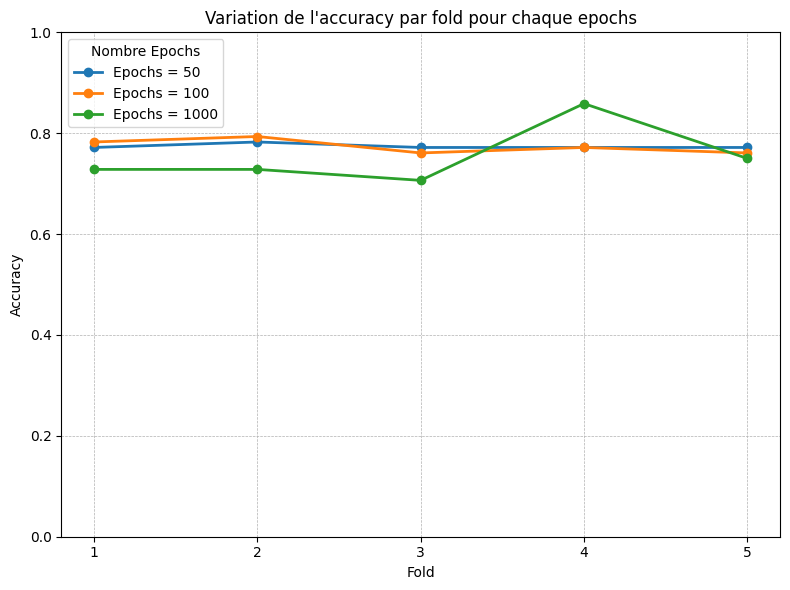

In [95]:


# 3. Validation croisée sur X_train / y_train
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_epochs = [50, 100, 1000]

# Initialisation du dictionnaire des scores
scores_by_nombre_epochs = {epoch: {'accuracy': []} for epoch in n_epochs}

# Dimensions du réseau
layer_sizes = [X_train.shape[1], 16, 8, 1]

for fold, (idx_tr, idx_va) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
    X_va, y_va = X_train[idx_va], y_train[idx_va]
    # reshape si nécessaire
    y_tr = y_tr.reshape(-1, 1)
    y_va = y_va.reshape(-1, 1)

    for epoch in n_epochs:
        # Ré-instanciation du modèle
        nn = NeuralNetwork(layer_sizes, model_optimization="Adam", learning_rate=0.001)
        # Entraînement
        nn.train(X_tr, y_tr, X_va, y_va, epochs=epoch, batch_size=64)
        # Prédiction sur le fold de validation
        y_pred_va = nn.predict(X_va)
        y_pred_va = (y_pred_va > 0.5).astype(int)
        # Stockage de l'accuracy
        acc = accuracy_score(y_va.ravel(), y_pred_va.ravel())
        scores_by_nombre_epochs[epoch]['accuracy'].append(acc)

# 4. Génération du graphique : accuracy par fold pour chaque learning rate
n_folds = len(next(iter(scores_by_nombre_epochs.values()))['accuracy'])
folds = np.arange(1, n_folds + 1)

plt.figure(figsize=(8, 6))
for epoch, metrics in scores_by_nombre_epochs.items():
    accs = metrics['accuracy']
    plt.plot(folds, accs, marker='o', linewidth=2, label=f'Epochs = {epoch}')

plt.title("Variation de l'accuracy par fold pour chaque epochs")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.xticks(folds)
plt.ylim(0.0, 1.0)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title="Nombre Epochs")
plt.tight_layout()
plt.show()

 Epoch 0 , Train Loss : 0.6885, Val Loss : 0.6895 ,  Train Acc : 0.6522 , Val Acc :0.6522
 Epoch 10 , Train Loss : 0.5433, Val Loss : 0.5448 ,  Train Acc : 0.7418 , Val Acc :0.7065
 Epoch 20 , Train Loss : 0.4662, Val Loss : 0.4727 ,  Train Acc : 0.7799 , Val Acc :0.7609
 Epoch 30 , Train Loss : 0.4506, Val Loss : 0.4625 ,  Train Acc : 0.7962 , Val Acc :0.7717
 Epoch 40 , Train Loss : 0.4421, Val Loss : 0.4609 ,  Train Acc : 0.8016 , Val Acc :0.7609
 Epoch 50 , Train Loss : 0.4355, Val Loss : 0.4610 ,  Train Acc : 0.7989 , Val Acc :0.7717
 Epoch 60 , Train Loss : 0.4294, Val Loss : 0.4622 ,  Train Acc : 0.8098 , Val Acc :0.7826
 Epoch 70 , Train Loss : 0.4241, Val Loss : 0.4646 ,  Train Acc : 0.8152 , Val Acc :0.7826
 Epoch 80 , Train Loss : 0.4192, Val Loss : 0.4663 ,  Train Acc : 0.8207 , Val Acc :0.7826
 Epoch 90 , Train Loss : 0.4147, Val Loss : 0.4658 ,  Train Acc : 0.8179 , Val Acc :0.7826
Fold 1 — acc:0.783, f1:0.677
 Epoch 0 , Train Loss : 0.6891, Val Loss : 0.6882 ,  Train Acc

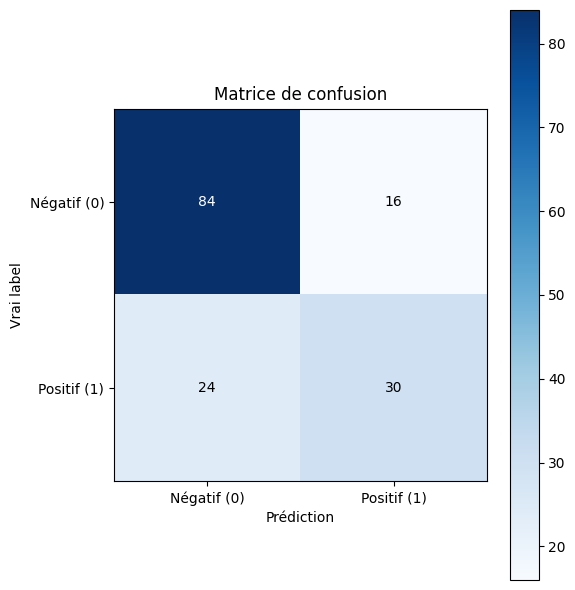

In [97]:
# Charger et p r p a r e r les d o n n e s
data=pd.read_csv('/content/sample_data/diabetes.csv')
X=data.drop('Outcome',axis=1).values
y=data['Outcome'].values
assert X. shape [0] == y. shape [0] , " Number of samples in X and y must match "
assert X. shape [1] == 8, " Expected 8 features in input data "

# Standardisation : X = (X - mu) / sigma
mu = np . mean (X , axis =0)
sigma = np . std (X , axis =0)
X = (X - mu) / sigma

# Diviser les d o n n e s en e n t r a n e m e n t , validation et test
X_temp , X_test , y_temp , y_test = train_test_split (X , y , test_size=0.2 , stratify =y , random_state =42)
X_train , X_val , y_train , y_val = train_test_split ( X_temp , y_temp ,test_size =0.25 , stratify = y_temp , random_state =42)
 # 0.25 x 0.8= 0.2
assert X_train . shape [0] + X_val . shape [0] + X_test . shape [0] == X.shape [0] , "Train -val - test split sizes must sum to total samples"

# Reshape target variables to be 2D
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


# C r e r et e n t r a n e r le m o d l e

# TODO : Ajouter une validation c r o i s e pour valuer la robustesse du m o d l e
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = {m: [] for m in ('accuracy','precision','recall','f1')}
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_va, y_va = X_train[test_idx], y_train[test_idx]

    # Reshape target variables to be 2D
    y_tr = y_tr.reshape(-1, 1)
    y_va = y_va.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # **IMPORTANT** : ré-instancier à chaque fold pour repartir à zéro
    layer_sizes = [ X_tr . shape [1], 16, 8, 1]
    nn = NeuralNetwork ( layer_sizes , model_optimization="Adam",learning_rate =0.001)

    # 1) entraînement
    train_losses , val_losses , train_accuracies , val_accuracies = nn .train ( X_tr , y_tr , X_va , y_va , epochs =100 , batch_size=64)

    # 2) prédiction
    y_pred = nn.predict(X_va)

    # 3) calcul des métriques
    scores['accuracy'].append(accuracy_score(y_va, y_pred))
    scores['precision'].append(precision_score(y_va, y_pred))
    scores['recall'].append(recall_score(y_va, y_pred))
    scores['f1'].append(f1_score(y_va, y_pred))

    print(f"Fold {fold} — acc:{scores['accuracy'][-1]:.3f}, "
          f"f1:{scores['f1'][-1]:.3f}")

# Enfin moyenne et écart-type
for m in scores:
    arr = np.array(scores[m])
    print(f"{m:9s}: {arr.mean():.3f} ± {arr.std():.3f}")


# TODO : I m p l m e n t e r l’optimiseur Adam pour une meilleure convergence

# P r d i c t i o n s et valuation
y_pred = nn . predict ( X_test )
print ("\ nRapport de classification ( Test set ) :")
print ( classification_report ( y_test , y_pred ))

# Matrice de confusion
cm = confusion_matrix ( y_test , y_pred )
print ("\ nMatrice de confusion ( Test set ) :")
print ( cm )


# 2) Affichage avec matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# 3) Configuration des labels
classes = ['Négatif (0)', 'Positif (1)']
ax.set(
    xticks=[0, 1],
    yticks=[0, 1],
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title="Matrice de confusion"
)

# 4) Annotation de chaque case
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

 Epoch 0 , Train Loss : 0.6862, Val Loss : 0.6862 ,  Train Acc : 0.6522 , Val Acc :0.6494
 Epoch 10 , Train Loss : 0.4538, Val Loss : 0.4450 ,  Train Acc : 0.8000 , Val Acc :0.7857
 Epoch 20 , Train Loss : 0.4375, Val Loss : 0.4466 ,  Train Acc : 0.8000 , Val Acc :0.7727
 Epoch 30 , Train Loss : 0.4260, Val Loss : 0.4417 ,  Train Acc : 0.8130 , Val Acc :0.7662
 Epoch 40 , Train Loss : 0.4166, Val Loss : 0.4475 ,  Train Acc : 0.8239 , Val Acc :0.7727
 Epoch 50 , Train Loss : 0.4079, Val Loss : 0.4408 ,  Train Acc : 0.8326 , Val Acc :0.7857
 Epoch 60 , Train Loss : 0.3962, Val Loss : 0.4545 ,  Train Acc : 0.8196 , Val Acc :0.7727
 Epoch 70 , Train Loss : 0.3837, Val Loss : 0.4489 ,  Train Acc : 0.8217 , Val Acc :0.7792
 Epoch 80 , Train Loss : 0.3676, Val Loss : 0.4550 ,  Train Acc : 0.8261 , Val Acc :0.7792
 Epoch 90 , Train Loss : 0.3566, Val Loss : 0.4606 ,  Train Acc : 0.8435 , Val Acc :0.7727


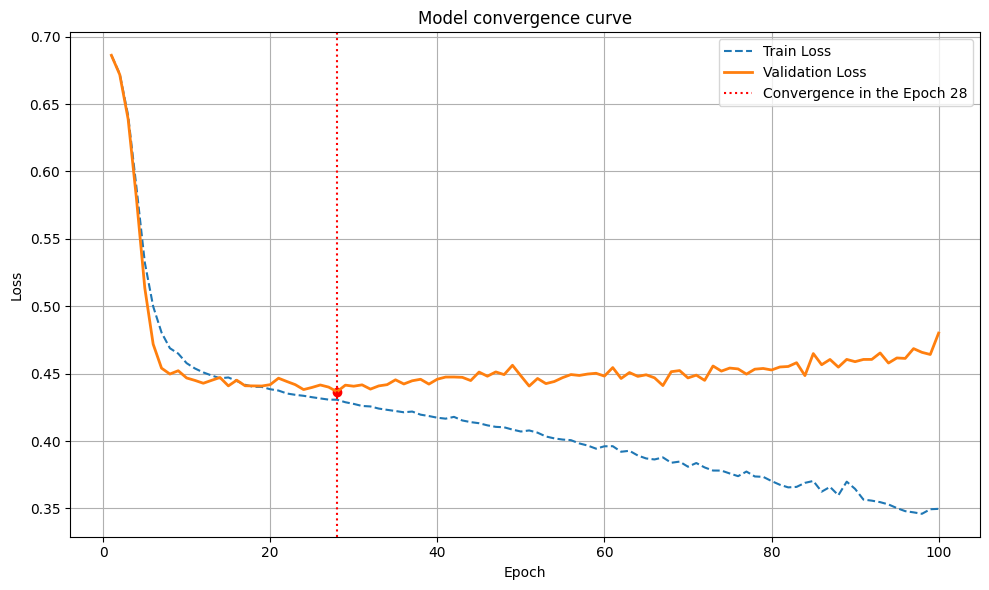

\ nRapport de classification ( Test set ) :
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       100
           1       0.60      0.57      0.58        54

    accuracy                           0.71       154
   macro avg       0.69      0.68      0.68       154
weighted avg       0.71      0.71      0.71       154



In [106]:
# Reshape target variables to be 2D
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


# C r e r et e n t r a n e r le m o d l e

# TODO : Ajouter une validation c r o i s e pour valuer la robustesse du m o d l e

# *IMPORTANT* : ré-instancier à chaque fold pour repartir à zéro
layer_sizes = [ X_train . shape [1], 32,16, 8, 1]
nn = NeuralNetwork ( layer_sizes , model_optimization="Adam",learning_rate =0.001)

# 1) entraînement
train_losses , val_losses , train_accuracies , val_accuracies = nn .train ( X_train , y_train , X_val , y_val , epochs =100 , batch_size=64)
epochs = range(1, len(train_losses) + 1)

# --- Détermination de l’epoch de convergence ---
# Ici : critère = minimum de la val_loss
best_epoch = np.argmin(val_losses) + 1
best_val_loss = val_losses[best_epoch - 1]

# Tu peux aussi utiliser : best_epoch = np.argmax(val_accuracies) + 1

# --- Affichage ---
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss", linestyle='--')
plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)
plt.axvline(best_epoch, color='red', linestyle=':', label=f"Convergence in the Epoch {best_epoch}")
plt.scatter(best_epoch, best_val_loss, color='red')
plt.title("Model convergence curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) prédiction
y_pred = nn.predict(X_test)


# TODO : I m p l m e n t e r l’optimiseur Adam pour une meilleure convergence

# P r d i c t i o n s et valuation
y_pred = nn . predict ( X_test )
print ("\ nRapport de classification ( Test set ) :")
print ( classification_report ( y_test , y_pred ))